# Data Science Bowl: Candidate Point Generation

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import dicom
import scipy.misc
import matplotlib.pyplot as plt
import skimage

from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi

%matplotlib inline
warnings.filterwarnings("ignore")

## Config & Environment

In [2]:
INPUT_FOLDER = 'stage1/'  # "samples/" or "stage1/"

patients = os.listdir(INPUT_FOLDER)
patients.sort()

## Utils

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)


def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + scan[0].PixelSpacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')
    
    return image


def read_ct_scan(folder_name):
    # Read the slices from the dicom file
    slices = [dicom.read_file(folder_name + filename) for filename in os.listdir(folder_name)]

    # Sort the dicom slices in their respective order
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness

    # Get the pixel values for all the slices
    image = np.stack([s.pixel_array for s in slices])
    image[image == -2000] = 0
    return slices, image


def get_batches(patients):
    for ix, patient in enumerate(patients):
        scan = read_ct_scan(INPUT_FOLDER + patient + '/')
        if ix % 50 == 0:
            print("Processing patient {0} of {1}".format(ix, len(patients)))
        yield scan
        

def save_array(path, arr):
    np.save(path, arr)
    

def load_array(path):
    return np.load(path)


def plot_ct_scan(scan):
    f, plots = plt.subplots(int(scan.shape[0] / 20) + 1, 4, figsize=(25, 25))
    for i in range(0, scan.shape[0], 5):
        plots[int(i / 20), int((i % 20) / 5)].axis('off')
        plots[int(i / 20), int((i % 20) / 5)].imshow(scan[i], cmap=plt.cm.bone) 
        
        
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

## Preprocessing

In [4]:
# holding off on this now because I don't think these values are right, plus we can do this step at model training

MIN_BOUND = -1000.0
MAX_BOUND = 400.0
PIXEL_MEAN = 0.25
    

def normalize(image):
    image = (image - MIN_BOUND) / (MAX_BOUND - MIN_BOUND)
    image[image>1] = 1.
    image[image<0] = 0.
    return image


def zero_center(image):
    image = image - PIXEL_MEAN
    return image

## Lung Segmentation

In [5]:
def get_segmented_lungs(im, plot=False):
    
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(8, 1, figsize=(5, 40))
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 604
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.bone) 
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    get_high_vals = binary == 0
    im[get_high_vals] = 0
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        
    return im


def segment_lung_from_ct_scan(ct_scan):
    return np.asarray([get_segmented_lungs(slice) for slice in ct_scan])

## Thresholding & Denoising

After filtering, there's still noise because of blood vessels, so remove the two largest connected components.

In [6]:
def denoise(segmented_ct_scan):
    
    try:
        selem = ball(2)
        binary = binary_closing(segmented_ct_scan, selem)

        label_scan = label(binary)

        areas = [r.area for r in regionprops(label_scan)]
        areas.sort()

        for r in regionprops(label_scan):
            max_x, max_y, max_z = 0, 0, 0
            min_x, min_y, min_z = 1000, 1000, 1000

            for c in r.coords:
                max_z = max(c[0], max_z)
                max_y = max(c[1], max_y)
                max_x = max(c[2], max_x)

                min_z = min(c[0], min_z)
                min_y = min(c[1], min_y)
                min_x = min(c[2], min_x)

            if (min_z == max_z or min_y == max_y or min_x == max_x or r.area > areas[-3]):
                for c in r.coords:
                    segmented_ct_scan[c[0], c[1], c[2]] = 0
            else:
                index = (max((max_x - min_x), (max_y - min_y), (max_z - min_z))) / (min((max_x - min_x), (max_y - min_y) , (max_z - min_z)))

        return segmented_ct_scan
    
    except Exception as e:
        print(e)
        return segmented_ct_scan

## Run Pipeline

In [7]:
gen = get_batches(patients)

for patient in patients:
    scan, image = next(gen)
    segmented = segment_lung_from_ct_scan(image)
    segmented[segmented < 604] = 0
    denoised = denoise(segmented)
#     normalized = normalize(resampled)
#     centered = zero_center(normalized)
    resampled = resample(denoised, scan)
    save_array("prepd_{0}{1}.npy".format(INPUT_FOLDER, patient), resampled)

Processing patient 0 of 1595
Processing patient 50 of 1595
Processing patient 100 of 1595
Processing patient 150 of 1595
Processing patient 200 of 1595
Processing patient 250 of 1595
Processing patient 300 of 1595
Processing patient 350 of 1595
Processing patient 400 of 1595
Processing patient 450 of 1595
Processing patient 500 of 1595
Processing patient 550 of 1595
Processing patient 600 of 1595
Processing patient 650 of 1595
Processing patient 700 of 1595
Processing patient 750 of 1595
Processing patient 800 of 1595
Processing patient 850 of 1595
Processing patient 900 of 1595
Processing patient 950 of 1595
Processing patient 1000 of 1595
Processing patient 1050 of 1595
Processing patient 1100 of 1595
Processing patient 1150 of 1595
Processing patient 1200 of 1595
Processing patient 1250 of 1595
Processing patient 1300 of 1595
Processing patient 1350 of 1595
Processing patient 1400 of 1595
Processing patient 1450 of 1595
Processing patient 1500 of 1595
Processing patient 1550 of 1595

##  Pipeline Visualization

Processing patient 0 of 1595


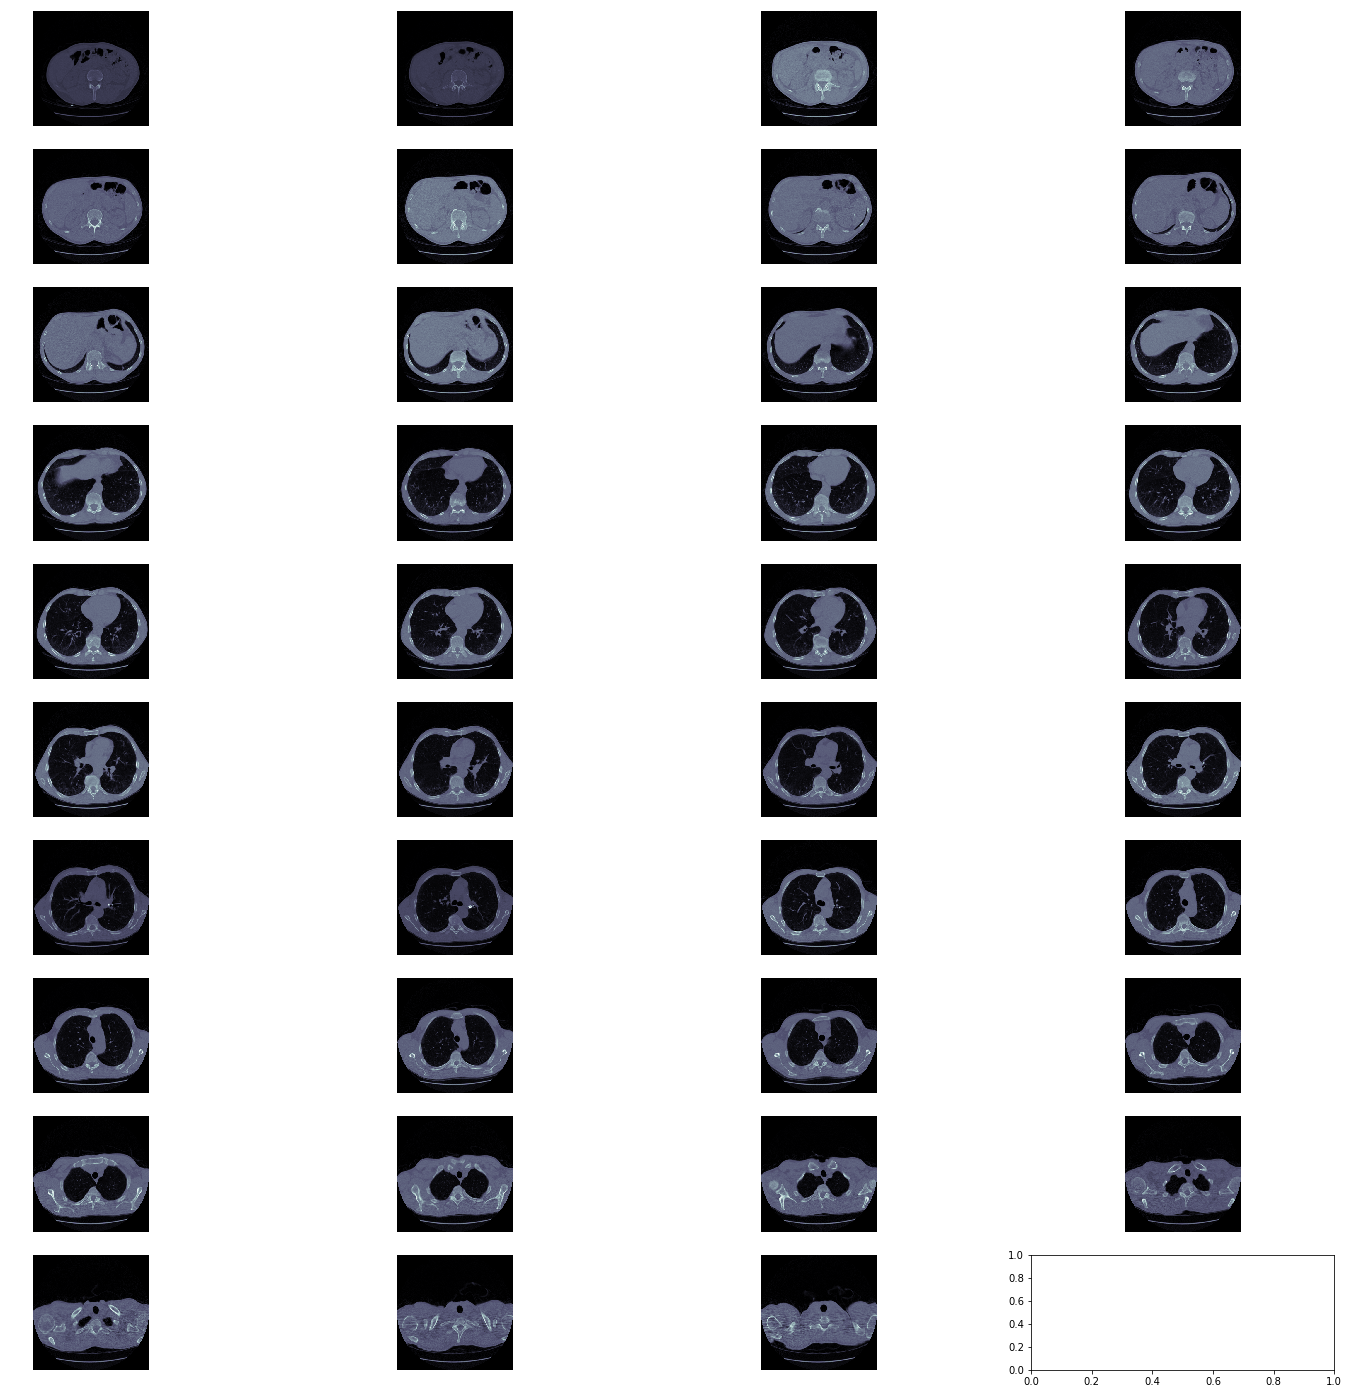

In [8]:
demo_gen = get_batches(patients)  # reset generator

scan, image = next(demo_gen)

plot_ct_scan(image)

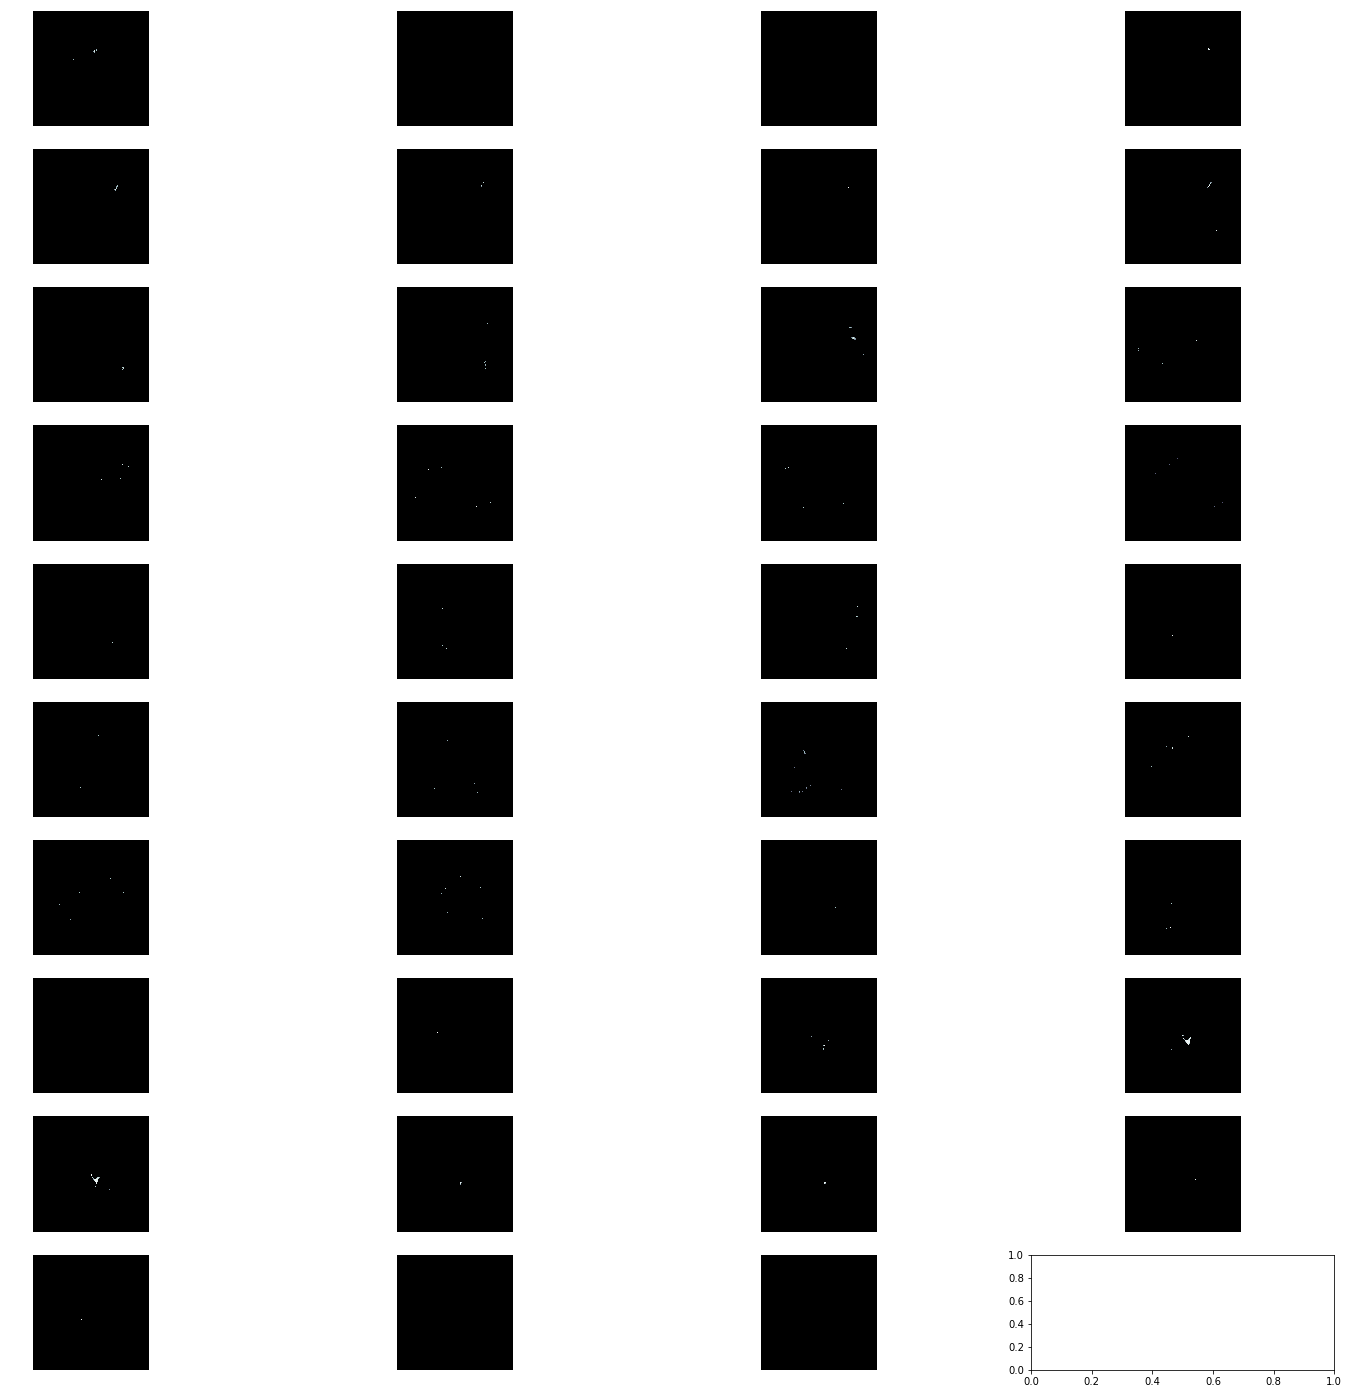

In [9]:
segmented = segment_lung_from_ct_scan(image)

segmented[segmented < 604] = 0
denoised = denoise(segmented)

plot_ct_scan(denoised)

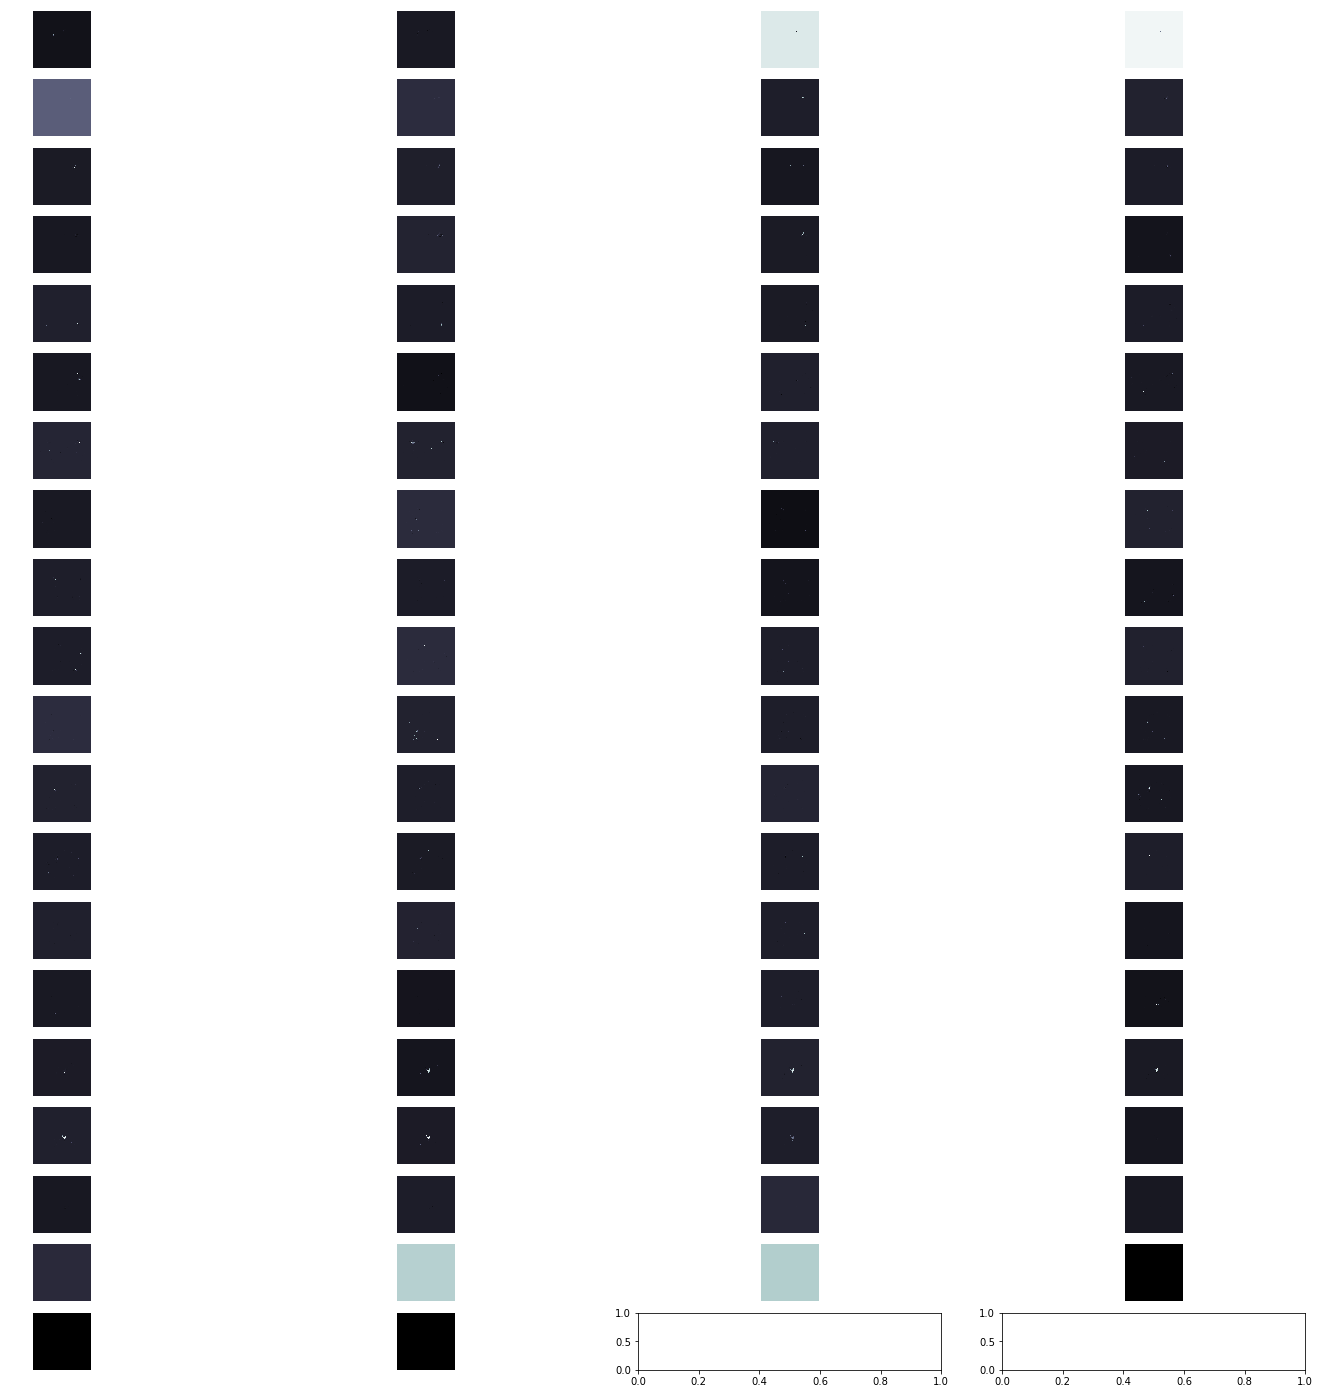

In [11]:
resampled = resample(denoised, scan)

plot_ct_scan(resampled)

In [12]:
print("Max pixel value:", np.max(resampled))
print("Min pixel value:", np.min(resampled))
print("Mean pixel value:", np.mean(resampled))
print("Std. dev of pixel values:", np.std(resampled))
print("\nImage dims:")


print("\n".join([str(slc.shape) for slc in resampled[:5]]))

Max pixel value: 2169
Min pixel value: -298
Mean pixel value: 0.338856189502
Std. dev of pixel values: 16.5127308496

Image dims:
(355, 355)
(355, 355)
(355, 355)
(355, 355)
(355, 355)


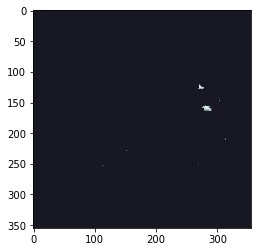

In [13]:
plt.imshow(resampled[100], cmap=plt.cm.bone)